# Probabilistic Programming - 2
## Variational inference

In this notebook, we are exploring a more complex problem set using variational inference, namely mixture modeling. It will show you how to deal with the multivariate case.

### Preliminaries

- Goal 
  - Write a variational inference procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Getting started with [ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).

## Mixture modeling

We will first generate a synthetic data set to play around with. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

┌ Info: Recompiling stale cache file /home/wmkouw/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


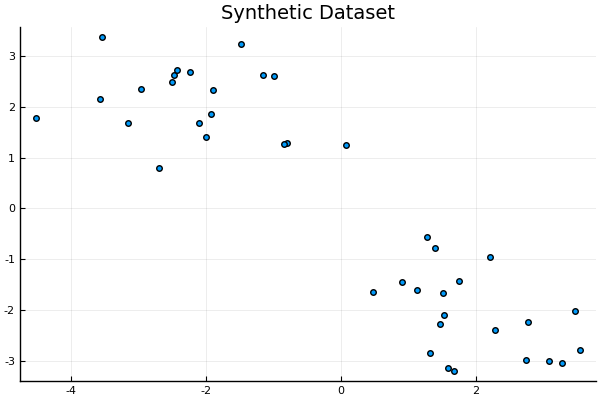

In [1]:
using Random
import Distributions: MvNormal, Normal, pdf
using Plots
pyplot()

# Set a random seed.
Random.seed!(3)

# Construct 10 data points for each cluster.
N = 20

# Means for each cluster, assuming each cluster is Gaussian distributed
μs = [[-2 +2]; [+2 -2]]

# Cluster 1
X1 = randn(N,2)
for i = 1:N
    X1[i,:] += μs[1,:]
end 
    
# Cluster 2
X2 = randn(N,2)
for i = 1:N
    X2[i,:] += μs[2,:]
end 
    
# Concatenate clusters
X = [X1; X2]

# ForneyLab needs every vector to be a row
X_ = [X[i,:] for i = 1:N*2]

# Visualization.
scatter(X[:,1], X[:,2], legend = false, title = "Synthetic Dataset")

### Variational inference

In [2]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV _pi ~ Beta(1.0, 1.0)
@RV m_1 ~ GaussianMeanVariance([0.0, 0.0], [1. 0.; 0. 1.])
@RV W_1 ~ Wishart([1. 0.; 0. 1.], 2.)
@RV m_2 ~ GaussianMeanVariance([0.0, 0.0], [1. 0.; 0. 1.])
@RV W_2 ~ Wishart([1. 0.; 0. 1.], 2.)

z = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for i = 1:N
    @RV z[i] ~ Bernoulli(_pi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, W_1, m_2, W_2)
    
    placeholder(y[i], :y, dims=(2,), index=i)
end

Now, you need to specify a distribution with which you will approximate the posterior distribution that you would normally obtain through exact Bayesian inference.

In [3]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(_pi, m_1, W_1, m_2, W_2, z, ids=[:PI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F))

freeEnergy (generic function with 1 method)

Now, we execute the algorithm

In [4]:
data = Dict(:y => X_)

# Prepare recognition distributions
marginals = Dict(:_pi => ProbabilityDistribution(Beta, a=1.0, b=1.0),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.0, +1.0], v=1e4*[1. 0.;0. 1.]),
                 :W_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=10*[1. 0.;0. 1.], nu=2.),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[+1.0, -1.0], v=1e4*[1. 0.;0. 1.]),
                 :W_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=10*[1. 0.;0. 1.], nu=2.)
                 )
for i = 1:N
    marginals[:z_*i] = ProbabilityDistribution(Bernoulli, p=1/2.)
end

# Execute algorithm
num_iterations = 20
F = Float64[]
for i = 1:num_iterations
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

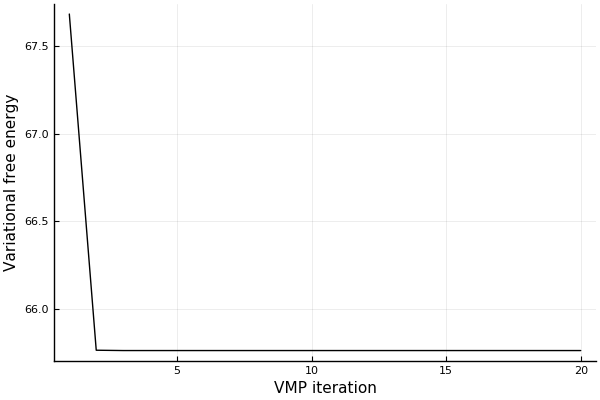

In [5]:
# Plot free energy to check for convergence
plot(1:num_iterations, F, color="black", label="")
xlabel!("VMP iteration")
ylabel!("Variational free energy")

Visualize the results.

┌ Info: Recompiling stale cache file /home/wmkouw/.julia/compiled/v1.1/Turing/gm4QC.ji for Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1184


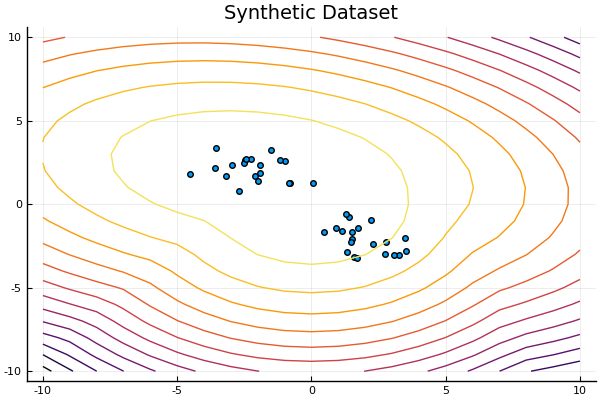

In [6]:
include("scripts/ppl-2.jl")

# Estimated means
μ1_estimated = mean(marginals[:m_1])
μ2_estimated = mean(marginals[:m_2])
v1_estimated = var(marginals[:m_1])
v2_estimated = var(marginals[:m_2])
Σ1_estimated = cholinv(mean(marginals[:W_1]))
Σ2_estimated = cholinv(mean(marginals[:W_2]))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated, Σ1_estimated, Σ2_estimated; x1=range(-10,stop=10), x2=range(-10,stop=10))

### A real-world problem

Let's have another look at the Old Faithful data set. Can we model it using our PPL's?

┌ Info: Recompiling stale cache file /home/wmkouw/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


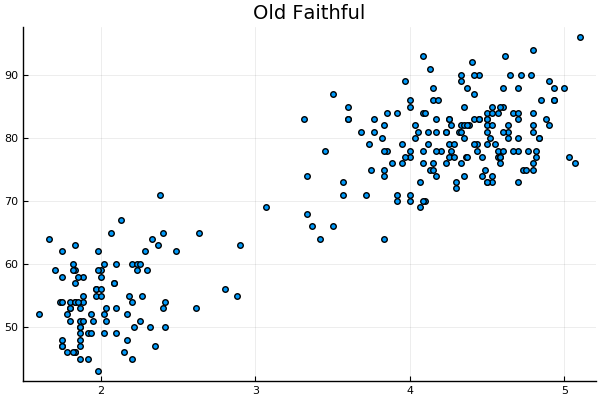

In [7]:
using DataFrames
using CSV
using LinearAlgebra

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, old_faithful)

# ForneyLab needs every vector to be a row
X_ = [X[i,:] for i = 1:size(X, 1)]

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

First of all, we should specify the model that we believe generated the data. 